# Multi Agents - 코드 리뷰 시스템 (중급)

## 개요
LangGraph를 활용하여 여러 에이전트가 병렬로 실행되고 결과를 집계하는 코드 리뷰 시스템을 구현합니다.

## 구성
1. **코드 분석 에이전트**: 코드 구조와 로직 파악
2. **버그 검사 에이전트**: 잠재적 버그와 오류 찾기
3. **스타일 검사 에이전트**: 코딩 컨벤션 및 스타일 확인
4. **성능 분석 에이전트**: 성능 이슈 및 최적화 제안
5. **통합 리포트 에이전트**: 모든 리뷰 결과 종합

## 학습 목표
- 병렬 실행 (parallel execution): 여러 에이전트 동시 실행
- 결과 집계 (aggregation): 각 에이전트 결과를 모아서 처리
- 독립적 작동: 각 에이전트가 서로 의존하지 않고 실행


## 1. 환경 설정 및 라이브러리 임포트


In [1]:
import os
from typing import TypedDict, List, Annotated
from operator import add
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

### API 키 설정
- [OpenAI API 키](https://platform.openai.com/api-keys)

In [ ]:
import os

# API 키 설정
os.environ["OPENAI_API_KEY"] = "sk-proj-"

# API 키 확인
openai_key = os.getenv("OPENAI_API_KEY")

if openai_key:
    print("OpenAI API 키가 설정되었습니다. (GPT 모델 사용)")
else:
    print("OpenAI API 키가 없습니다.")

OpenAI API 키가 설정되었습니다. (GPT 모델 사용)


### LLM 초기화

In [3]:
# LLM 초기화
llm = ChatOpenAI(model="gpt-5-nano")

## 2. 상태 정의 (State Management)

병렬 실행을 위한 상태 구조를 정의합니다. `Annotated`와 `add` 연산자를 사용하여 각 에이전트의 결과를 리스트에 집계합니다.


In [4]:
class ReviewState(TypedDict):
    """
    코드 리뷰 시스템의 상태를 정의하는 클래스
    
    Attributes:
        code: 리뷰할 코드
        reviews: 각 에이전트의 리뷰 결과 리스트 (자동 집계)
        final_report: 통합 리포트
    """
    code: str
    reviews: Annotated[List[str], add]  # add 연산자로 자동 집계
    final_report: str

print("상태 구조가 정의되었습니다.")
print("reviews 필드는 Annotated[List[str], add]로 정의되어 자동으로 결과를 집계합니다.")


상태 구조가 정의되었습니다.
reviews 필드는 Annotated[List[str], add]로 정의되어 자동으로 결과를 집계합니다.


## 3. 병렬 실행 에이전트 정의

각 에이전트는 독립적으로 코드를 분석하고, 결과를 `reviews` 리스트에 추가합니다.


### 3.1 코드 분석 에이전트


In [ ]:
def code_analysis_agent(state: ReviewState) -> dict:
    """
    코드의 구조와 로직을 분석하는 에이전트
    """
    code = state["code"]
    
    messages = [
        SystemMessage(content="""
            당신은 코드 구조 분석 전문가입니다.
            다음 관점에서 코드를 분석하세요:
            - 전체적인 구조와 설계 패턴
            - 함수/클래스의 역할과 책임
            - 코드의 가독성과 유지보수성
            - 모듈화 수준

            간결하고 명확하게 분석 결과를 제공하세요."""),
        HumanMessage(content=f"다음 코드를 분석하세요:\n\n{code}")
    ]
    
    response = llm.invoke(messages)
    review = f"[코드 구조 분석]\n{response.content}"
    
    print("[코드 분석 에이전트] 분석 완료")
    
    return {
        "reviews": [review]  # 리스트로 반환하여 자동 집계
    }


### 3.2 버그 검사 에이전트


In [ ]:
def bug_detection_agent(state: ReviewState) -> dict:
    """
    잠재적 버그와 오류를 찾는 에이전트
    """
    code = state["code"]
    
    messages = [
        SystemMessage(content="""
            당신은 버그 탐지 전문가입니다.
            다음 관점에서 코드를 검사하세요:
            - 논리적 오류 가능성
            - 예외 처리 누락
            - Null/Undefined 참조 위험
            - 경계 조건 처리
            - 리소스 누수 가능성

            발견된 문제와 해결 방안을 제시하세요."""),
        HumanMessage(content=f"다음 코드에서 버그를 찾으세요:\n\n{code}")
    ]
    
    response = llm.invoke(messages)
    review = f"[버그 검사]\n{response.content}"
    
    print("[버그 검사 에이전트] 검사 완료")
    
    return {
        "reviews": [review]
    }


### 3.3 스타일 검사 에이전트


In [ ]:
def style_check_agent(state: ReviewState) -> dict:
    """
    코딩 컨벤션과 스타일을 검사하는 에이전트
    """
    code = state["code"]
    
    messages = [
        SystemMessage(content="""
            당신은 코딩 스타일 전문가입니다.
            다음 관점에서 코드를 검사하세요:
            - 네이밍 컨벤션 (변수, 함수, 클래스명)
            - 코드 포맷팅 (들여쓰기, 줄바꿈)
            - 주석의 적절성
            - 코드 일관성
            - 베스트 프랙티스 준수 여부

            개선 사항을 구체적으로 제안하세요."""),
        HumanMessage(content=f"다음 코드의 스타일을 검사하세요:\n\n{code}")
    ]
    
    response = llm.invoke(messages)
    review = f"[스타일 검사]\n{response.content}"
    
    print("[스타일 검사 에이전트] 검사 완료")
    
    return {
        "reviews": [review]
    }


### 3.4 성능 분석 에이전트


In [ ]:
def performance_analysis_agent(state: ReviewState) -> dict:
    """
    성능 이슈를 분석하고 최적화 방안을 제안하는 에이전트
    """
    code = state["code"]
    
    messages = [
        SystemMessage(content="""
            당신은 성능 최적화 전문가입니다.
            다음 관점에서 코드를 분석하세요:
            - 시간 복잡도와 공간 복잡도
            - 불필요한 연산이나 중복 코드
            - 메모리 사용 효율성
            - 알고리즘 최적화 가능성
            - 병목 지점

            구체적인 최적화 방안을 제시하세요."""),
        HumanMessage(content=f"다음 코드의 성능을 분석하세요:\n\n{code}")
    ]
    
    response = llm.invoke(messages)
    review = f"[성능 분석]\n{response.content}"
    
    print("[성능 분석 에이전트] 분석 완료")
    
    return {
        "reviews": [review]
    }


## 4. 결과 집계 에이전트

모든 병렬 에이전트의 결과를 받아 통합 리포트를 생성합니다.


In [ ]:
def aggregation_agent(state: ReviewState) -> dict:
    """
    모든 리뷰 결과를 종합하여 최종 리포트를 생성하는 에이전트
    """
    code = state["code"]
    reviews = state["reviews"]
    
    # 모든 리뷰 결과를 하나의 문자열로 결합
    all_reviews = "\n\n".join(reviews)
    
    messages = [
        SystemMessage(content="""
            당신은 시니어 코드 리뷰어입니다.
            여러 전문가들의 리뷰 결과를 받았습니다. 이를 종합하여:
            1. 주요 발견 사항 요약
            2. 우선순위별 개선 사항 정리
            3. 전체적인 코드 품질 평가
            4. 구체적인 액션 아이템 제시

            명확하고 실행 가능한 최종 리포트를 작성하세요."""),
        HumanMessage(content=f"다음은 각 전문가들의 리뷰입니다:\n\n{all_reviews}\n\n이를 종합하여 최종 리포트를 작성하세요.")
    ]
    
    response = llm.invoke(messages)
    final_report = response.content
    
    print("[통합 리포트 에이전트] 최종 리포트 생성 완료")
    
    return {
        "final_report": final_report
    }


## 5. 그래프 구성 (병렬 실행)

여러 에이전트가 동시에 실행되도록 그래프를 구성합니다.

### 그래프 구조
```
                    시작
                     |
                     v
         +-----------+-----------+
         |           |           |
         v           v           v
  코드 분석    버그 검사    스타일 검사
         |           |           |
         +-----+-----+-----------+
               |           |
               v           v
          성능 분석   (병렬 실행)
               |
               v
          통합 리포트
               |
               v
             종료
```


In [10]:
# StateGraph 생성
workflow = StateGraph(ReviewState)

# 병렬 실행될 노드들 추가
workflow.add_node("code_analysis", code_analysis_agent)
workflow.add_node("bug_detection", bug_detection_agent)
workflow.add_node("style_check", style_check_agent)
workflow.add_node("performance_analysis", performance_analysis_agent)

# 결과 집계 노드 추가
workflow.add_node("aggregation", aggregation_agent)

# 시작점 설정 - 4개의 에이전트로 동시 분기
workflow.set_entry_point("code_analysis")
workflow.set_entry_point("bug_detection")
workflow.set_entry_point("style_check")
workflow.set_entry_point("performance_analysis")

# 모든 병렬 에이전트에서 집계 에이전트로 연결
workflow.add_edge("code_analysis", "aggregation")
workflow.add_edge("bug_detection", "aggregation")
workflow.add_edge("style_check", "aggregation")
workflow.add_edge("performance_analysis", "aggregation")

# 집계 에이전트에서 종료
workflow.add_edge("aggregation", END)

# 그래프 컴파일
app = workflow.compile()

print("병렬 실행 그래프가 성공적으로 구성되었습니다!")
print("4개의 에이전트가 동시에 실행되고, 결과가 자동으로 집계됩니다.")


병렬 실행 그래프가 성공적으로 구성되었습니다!
4개의 에이전트가 동시에 실행되고, 결과가 자동으로 집계됩니다.


## 6. 그래프 시각화 (선택사항)


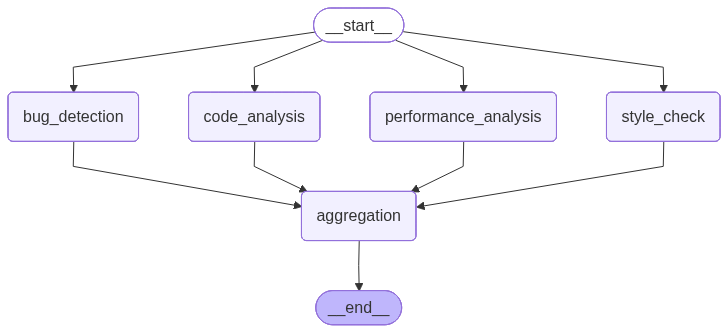

In [11]:
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"그래프 시각화를 위해서는 graphviz가 필요합니다: {e}")
    print("텍스트로 그래프 구조를 확인하세요:")
    print(app.get_graph())


## 7. 테스트 예제

실제 코드를 리뷰하는 예제입니다.


### 7.1 테스트 코드 준비


In [12]:
# 리뷰할 샘플 코드 (의도적으로 개선 여지가 있는 코드)
sample_code = """
def find_duplicates(list):
    result = []
    for i in range(len(list)):
        for j in range(len(list)):
            if i != j and list[i] == list[j]:
                if list[i] not in result:
                    result.append(list[i])
    return result

def calculate_average(numbers):
    sum = 0
    for n in numbers:
        sum = sum + n
    avg = sum / len(numbers)
    return avg

class userManager:
    def __init__(self):
        self.users = []
    
    def add_user(self, name, age):
        self.users.append({'name': name, 'age': age})
    
    def get_user(self, name):
        for user in self.users:
            if user['name'] == name:
                return user
        return None
"""

print("샘플 코드가 준비되었습니다.")


샘플 코드가 준비되었습니다.


### 7.2 코드 리뷰 실행


In [13]:
print("=" * 80)
print("코드 리뷰 시작")
print("=" * 80)

# 초기 상태 생성
initial_state = {
    "code": sample_code,
    "reviews": [],
    "final_report": ""
}

# 그래프 실행 (병렬 실행)
result = app.invoke(initial_state)

print("\n" + "=" * 80)
print("코드 리뷰 완료!")
print("=" * 80)


코드 리뷰 시작


Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[코드 분석 에이전트] 분석 완료


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[성능 분석 에이전트] 분석 완료


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[버그 검사 에이전트] 검사 완료


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[스타일 검사 에이전트] 검사 완료


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[통합 리포트 에이전트] 최종 리포트 생성 완료

코드 리뷰 완료!


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


### 7.3 개별 리뷰 결과 확인


In [14]:
print("\n" + "=" * 80)
print("개별 에이전트 리뷰 결과")
print("=" * 80)

for i, review in enumerate(result["reviews"], 1):
    print(f"\n리뷰 {i}:")
    print("-" * 80)
    print(review)
    print()



개별 에이전트 리뷰 결과

리뷰 1:
--------------------------------------------------------------------------------
[버그 검사]
다음 코드에서 발견되는 버그/취약점과 개선 방안을 정리합니다.

1) find_duplicates(list)
- 문제점
  - 매개변수 이름이 Python의 내장 타입 이름인 list와 같은 이름으로 되어 있어 가독성과 혼동의 위험이 있습니다.
  - 입력 검증 부재로 None 또는 비 리스트형 입력에 대해 명확한 예외를 주지 않습니다.
  - 이중 루프(O(n^2))로 비효율적이며, 필요 시 더 빠른 구현이 가능합니다.
  - 경계 조건: 빈 리스트를 입력하면 빈 결과를 반환하지만, 명시적인 예외 처리나 경계 체크를 추가해 의도를 명확히 할 수 있습니다.
- 개선 제안
  - 매개변수명을 items 또는 values로 변경하고 입력을 검증합니다.
  - 시간 복잡도를 줄이고, 원하면 원소의 등장 여부를 유지하는 방식으로 중복 원소를 한 번만 반환하도록 구현합니다.
  - 예시 구현(A: 순서를 보존하지 않는 간단 버전, B: 순서를 보존하면서 중복을 하나씩만 반환하는 버전)

A 버전(간단하고 성능 개선 가능):
- 코드:
def find_duplicates(values):
    if values is None:
        raise ValueError("values must not be None")
    seen = set()
    duplicates = set()
    for v in values:
        if v in seen:
            duplicates.add(v)
        else:
            seen.add(v)
    return list(duplicates)

B 버전(순서를 보존하며 중복을 처음 등장한 순서대로 수집):
- 코드:
def find_duplicates(values):
    if val

### 7.4 통합 리포트 확인


In [15]:
print("\n" + "=" * 80)
print("최종 통합 리포트")
print("=" * 80)
print()
print(result["final_report"])
print()
print("=" * 80)



최종 통합 리포트

다음은 제공된 전문가 리뷰를 종합한 최종 코드 품질 리포트입니다. 목적은 현재 구조의 문제를 명확히 파악하고, 실행 가능한 개선 로드맷을 제시하는 데 있습니다.

1) 주요 발견 사항 요약
- 구조/설계
  - 한 파일에 소규모 유틸리티와 간단한 저장소가 같이 있어 모듈화와 재사용성이 떨어짐.
  - 데이터 모델과 저장소의 경계가 모호해 확장성 및 테스트 용이성이 저하됨.
- find_duplicates의 문제점 및 개선 필요성
  - 매개변수 이름이 내장 타입 이름(list)과 중복되어 가독성 저하 및 혼동 위험 있음.
  - None 또는 비 리스트형 입력에 대한 입력 검증 부재.
  - 이중 루프 기반 구현으로 비효율적이며, 최악의 경우 O(n^3) 수준의 비용도 야기 가능.
  - 순서를 보존해야 하는지 여부에 따라 구현 방식이 다르고, 중복 값을 한 번만 반환하는 방식으로의 개선이 필요.
- calculate_average의 문제점 및 개선 필요성
  - sum이라는 로컬 변수 이름이 파이썬의 내장 sum을 그림자(오버라이드)함.
  - 입력이 비어 있으면 0으로 나누는 ZeroDivisionError 가능성 존재.
  - None/비수치형 요소에 대한 입력 검증이 미흡.
- class userManager의 문제점 및 개선 필요성
  - 클래스 이름이 파이썬 스타일(Pep8)과 다르게 작성되어 가독성 저하.
  - 입력 검증 부재: name이 None이거나 age가 음수인 경우 등 잘못된 데이터 수용 가능성.
  - get_user에서 키 접근 시 KeyError 위험이 있으며, 전체적으로 검색이 선형 탐색으로 비효율적임.
  - 다중 동일 이름 처리 정책이 불명확하고, 변경 가능성 높은 요구사항에 대응하기 어렵다.
- 스타일/문서화
  - docstring, 타입 힌트 부재로 의도 파악 및 정적 분석의 이점이 거의 없음.
  - 네이밍 컨벤션 혼재, 빌트인 이름 충돌 위험, 중복 검사 로직의 비효율성 등 스타일 규칙 위반 다수

## 8. 재사용 가능한 리뷰 함수


In [16]:
def review_code(code: str, show_individual_reviews: bool = False):
    """
    코드를 리뷰하는 함수
    
    Args:
        code: 리뷰할 코드
        show_individual_reviews: 개별 리뷰 결과 표시 여부
    
    Returns:
        리뷰 결과 딕셔너리
    """
    print("\n" + "=" * 80)
    print("코드 리뷰 시작")
    print("=" * 80)
    
    initial_state = {
        "code": code,
        "reviews": [],
        "final_report": ""
    }
    
    result = app.invoke(initial_state)
    
    if show_individual_reviews:
        print("\n[개별 리뷰 결과]")
        for i, review in enumerate(result["reviews"], 1):
            print(f"\n--- 리뷰 {i} ---")
            print(review)
    
    print("\n" + "=" * 80)
    print("[최종 통합 리포트]")
    print("=" * 80)
    print(result["final_report"])
    print("=" * 80)
    
    return result

# 사용 예시
# review_code(your_code, show_individual_reviews=True)
